# STDP - MNIST
#### Coder: Janilbols
#### Create Date: 21.Nov.2018
#### Last Edit Date: 21.Nov.2018
#### Description: 
    This is the first edition of STDP-MNIST. Using STDP as training logic, and MNIST as test case.

#### TODO:

1. Script for (init) build up Neural Net
2. Functions for generate current, based on input
3. Script (loop) for stimulation
4. Functions for evaluation
5. Script for plotting

#### Further Work:

1. Packup the function as toolkit
2. Clear up the script

In [1]:
from math import exp
import numpy
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from pyNN.parameters import Sequence
from importlib import import_module

## === simulator para & options ===


In [2]:
op_simulator = "neuron"
op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True

## === Parameters ===

In [3]:
firing_period = 100.0    # (ms) interval between spikes
cell_parameters = {
    "tau_m": 10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 2,  # (ms) long refractory period to prevent bursting
}
n = 60                  # number of synapses / number of presynaptic neurons
delta_t = 1.0            # (ms) time difference between the firing times of neighbouring neurons
t_stop = 10 * firing_period + n * delta_t
delay = 0.01              # (ms) synaptic time delay, default=3.0

## === Configure the simulator ===

In [4]:
sim = import_module("pyNN."+op_simulator)

if op_debug: 
    init_logging(None, debug=True)

sim.setup(timestep=0.01, min_delay=delay, max_delay=delay)

0

In [15]:
for i in range(n):
    j = (i - n // 2)
    print numpy.arange(firing_period + j * delta_t, t_stop, firing_period)


[ 70. 170. 270. 370. 470. 570. 670. 770. 870. 970.]
[ 71. 171. 271. 371. 471. 571. 671. 771. 871. 971.]
[ 72. 172. 272. 372. 472. 572. 672. 772. 872. 972.]
[ 73. 173. 273. 373. 473. 573. 673. 773. 873. 973.]
[ 74. 174. 274. 374. 474. 574. 674. 774. 874. 974.]
[ 75. 175. 275. 375. 475. 575. 675. 775. 875. 975.]
[ 76. 176. 276. 376. 476. 576. 676. 776. 876. 976.]
[ 77. 177. 277. 377. 477. 577. 677. 777. 877. 977.]
[ 78. 178. 278. 378. 478. 578. 678. 778. 878. 978.]
[ 79. 179. 279. 379. 479. 579. 679. 779. 879. 979.]
[ 80. 180. 280. 380. 480. 580. 680. 780. 880. 980.]
[ 81. 181. 281. 381. 481. 581. 681. 781. 881. 981.]
[ 82. 182. 282. 382. 482. 582. 682. 782. 882. 982.]
[ 83. 183. 283. 383. 483. 583. 683. 783. 883. 983.]
[ 84. 184. 284. 384. 484. 584. 684. 784. 884. 984.]
[ 85. 185. 285. 385. 485. 585. 685. 785. 885. 985.]
[ 86. 186. 286. 386. 486. 586. 686. 786. 886. 986.]
[ 87. 187. 287. 387. 487. 587. 687. 787. 887. 987.]
[ 88. 188. 288. 388. 488. 588. 688. 788. 888. 988.]
[ 89. 189. 2

## === Build the network ===

In [14]:
def build_spike_sequences(period, duration, n, delta_t):
    """
    Return a spike time generator for `n` neurons (spike sources), where
    all neurons fire with the same period, but neighbouring neurons have a relative
    firing time difference of `delta_t`.
    """
    def spike_time_gen(i):
        """Spike time generator. `i` should be an array of indices."""
        return [Sequence(numpy.arange(period + j * delta_t, duration, period)) for j in (i - n // 2)]
    return spike_time_gen

spike_sequence_generator = build_spike_sequences(firing_period, t_stop, n, delta_t)
# presynaptic population
p_in = sim.Population(n, sim.SpikeSourceArray(spike_times=spike_sequence_generator),
                    label="presynaptic")
# single postsynaptic neuron
p_mid_1 = sim.Population(60, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="postsynaptic_1")
p_mid_2 = sim.Population(1, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="postsynaptic_2")
# drive to the postsynaptic neuron, ensuring it fires at exact multiples of the firing period
p_out = sim.Population(1, sim.SpikeSourceArray(spike_times=numpy.arange(firing_period - delay, t_stop, firing_period)),
                    label="driver")

# we set the initial weights to be very small, to avoid perturbing the firing times of the
# postsynaptic neurons
stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=0.00000005,
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))
connections_1 = sim.Projection(p_in, p_mid_1, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=10.0, delay=delay))
connections_2 = sim.Projection(p_mid_1, p_mid_2, sim.AllToAllConnector(), stdp_model)

# the connection weight from the driver neuron is very strong, to ensure the
# postsynaptic neuron fires at the correct times

driver_connection = sim.Projection(p_out, p_mid_2, sim.OneToOneConnector(), # sim.AllToAllConnector(),#
                                   sim.StaticSynapse(weight=10.0, delay=delay))


## == Instrument the network ===

In [6]:
p_in.record('spikes')
p_mid_1.record(['spikes', 'v'])
p_mid_2.record(['spikes', 'v'])


class WeightRecorder(object):
    """
    Recording of weights is not yet built in to PyNN, so therefore we need
    to construct a callback object, which reads the current weights from
    the projection at regular intervals.
    """

    def __init__(self, sampling_interval, projection):
        self.interval = sampling_interval
        self.projection = projection
        self._weights = []

    def __call__(self, t):
        self._weights.append(self.projection.get('weight', format='list', with_address=False))
        return t + self.interval

    def get_weights(self):
        signal = neo.AnalogSignal(self._weights, units='nA', sampling_period=self.interval * ms,
                                  name="weight")
        signal.channel_index = neo.ChannelIndex(numpy.arange(len(self._weights[0])))
        return signal

weight_recorder_1 = WeightRecorder(sampling_interval=1.0, projection=connections_1)
weight_recorder_2 = WeightRecorder(sampling_interval=1.0, projection=connections_2)


## === Run the simulation ===

In [7]:
sim.run(t_stop, callbacks=[weight_recorder_1,weight_recorder_2]) #

109.99999999997245

In [8]:
# === Save the results =============================

filename = normalized_filename("Results", "hello_stdp", "pkl", op_simulator)
p_mid_2.write_data(filename, annotations={'script_name': "Janilbols - PyNN - Test"})

presynaptic_data = p_in.get_data().segments[0]
postsynaptic_data_1 = p_mid_1.get_data().segments[0]
postsynaptic_data_2 = p_mid_2.get_data().segments[0]

print("Post-synaptic 1 spike times: %s" % postsynaptic_data_1.spiketrains[0])
print("Post-synaptic 2 spike times: %s" % postsynaptic_data_2.spiketrains[0])

weights_1 = weight_recorder_1.get_weights()
weights_2 = weight_recorder_2.get_weights()
final_weights_1 = numpy.array(weights_1[-1])
final_weights_2 = numpy.array(weights_2[-1])
deltas_1 = delta_t * numpy.arange(n // 2, -n // 2, -1)
print("Final weights - 1: %s\n\n" % final_weights_1)
deltas_2 = delta_t * numpy.arange(n // 2, -n // 2, -1)
print("Final weights - 2: %s\n\n" % final_weights_2)
plasticity_data_1 = DataTable(deltas_1, final_weights_1)
plasticity_data_2 = DataTable(deltas_2, final_weights_2)

Post-synaptic 1 spike times: [70.03] ms
Post-synaptic 2 spike times: [100.02] ms
Final weights - 1: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10.]


Final weights - 2: [5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 5.00000000e-08 5.00000000e-08
 5.00000000e-08 5.00000000e-08 4.88011994e-08 4.88596656e-08
 4.89152804e-08 4.89681828e-08 4.90185051e-08 4.90663732e-08
 4.91119067e-08 4.91552195e-08 4.91964199e-08 4.92356110e-08
 5.00000000e-08 5.000000

In [9]:
## === optionally plot a figure ===

Results/20181121/hello_stdp_neuron_20181121-105428.png


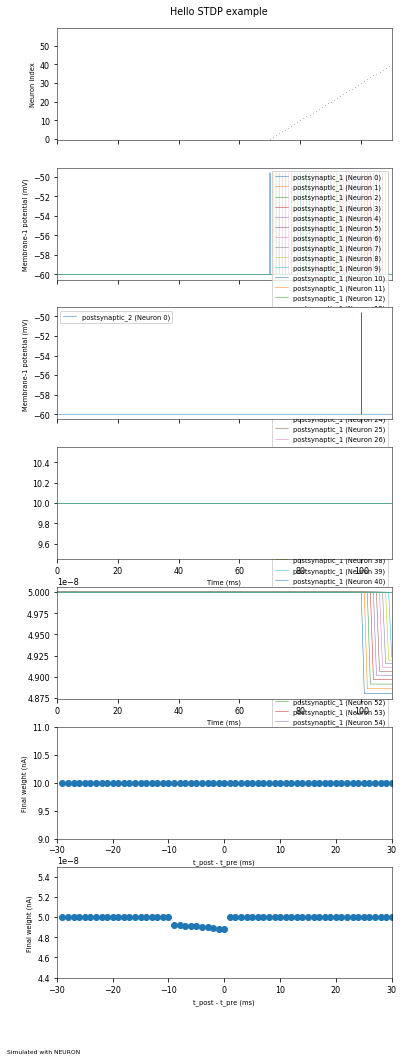

In [10]:

if op_fit_curve:
    def double_exponential(t, t0, w0, wp, wn, tau):
        return w0 + numpy.where(t >= t0, wp * numpy.exp(-(t - t0) / tau), wn * numpy.exp((t - t0) / tau))
    p0 = (-1.0, 5e-8, 1e-8, -1.2e-8, 20.0)
    popt, pcov = plasticity_data.fit_curve(double_exponential, p0, ftol=1e-10)
    print("Best fit parameters: t0={0}, w0={1}, wp={2}, wn={3}, tau={4}".format(*popt))


if op_plot_figure:
    from pyNN.utility.plotting import Figure, Panel, DataTable
    figure_filename = filename.replace("pkl", "png")
    Figure(
        # raster plot of the presynaptic neuron spike times
        Panel(presynaptic_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, t_stop)),
        # membrane potential of the postsynaptic neuron 1
        Panel(postsynaptic_data_1.filter(name='v')[0],
              ylabel="Membrane-1 potential (mV)",
              data_labels=[p_mid_1.label], yticks=True, xlim=(0, t_stop)),
        # membrane potential of the postsynaptic neuron 1
        Panel(postsynaptic_data_2.filter(name='v')[0],
              ylabel="Membrane-1 potential (mV)",
              data_labels=[p_mid_2.label], yticks=True, xlim=(0, t_stop)),
        # evolution of the synaptic weights with time
        Panel(weights_1, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(0, t_stop)),
        # evolution of the synaptic weights with time
        Panel(weights_2, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(0, t_stop)),
        # scatterplot of the final weight of each synapse against the relative
        # timing of pre- and postsynaptic spikes for that synapse
        Panel(plasticity_data_1,  
              xticks=True, yticks=True, xlim=(-n / 2 * delta_t, n / 2 * delta_t),
              ylim=(0.9 * final_weights_1.min(), 1.1 * final_weights_1.max()),
              xlabel="t_post - t_pre (ms)", ylabel="Final weight (nA)",
              show_fit=op_fit_curve),
        Panel(plasticity_data_2,  
              xticks=True, yticks=True, xlim=(-n / 2 * delta_t, n / 2 * delta_t),
              ylim=(0.9 * final_weights_2.min(), 1.1 * final_weights_2.max()),
              xlabel="t_post - t_pre (ms)", ylabel="Final weight (nA)",
              show_fit=op_fit_curve),
        title="Hello STDP example",
        annotations="Simulated with %s" % op_simulator.upper()
    ).save(figure_filename)
    print(figure_filename)


In [11]:
# === Clean up and quit ========================================================
sim.end()

In [4]:
# === Toolkit Usage ============================================================
%matplotlib inline
from data_handler import *

In [5]:
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
train_data, train_label, test_data, test_label, train_one_hot, test_one_hot = dh.get_data_nparray()
dh.displayID('train', 2)